# Steady-State Pumping in Confined Aquifer

This is a simulation of two pumping wells in a confined aquifer under steady state conditions. The wells are closer together than scenario 1.

## Assignment
This is a steady state box model.

## Model Description
#### Dimensions
- dx= 100m
- dy= 100m
- dz= 50m
- 25x25x1 grid

#### Subsurface properties

- Homogenous
- specific storage= 1*10^(-5)


### 1. Import Packages and Create Model Object

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import os

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/flopy


In [2]:
#create model object
modelname = "Pumping_Modeltre_twoWEL"
moddir="/Applications/MODFLOW/mf2005"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)
#moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"

#delete old run files
run = 'n'
if run == 'y':
    file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    for ext in file_extensions:
        os.remove(modelname + ext)

### 2. Discretize Model and Attach DIS Package

In [3]:
#assign discretization variables
Lx = 100.
Ly = 100.
ztop = 50.
zbot = 0.
nlay = 1
nrow = 100
ncol = 100
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay

#specify number of stress periods
nper = 1

#specify if stress period is transient or steady-state
steady = [True]

#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

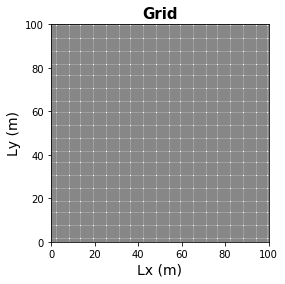

In [4]:
#CHECK GRID
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

### 3. Assign Cell Activity/Starting Heads and Attach BAS Package

In [5]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
#assign left and right boundary cells to constant head
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
ibound[:,0,:] = -1
ibound[:,-1,:] = -1

#create strt as array of floats = 10m  #strt is H_init
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, :] = 10.

#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

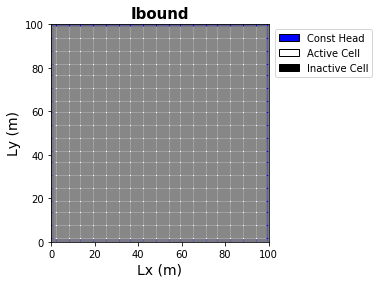

In [6]:
#CHECK IBOUND
#use flopy to plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

### 4. Define Layer Properties and Attach LPF Package

In [7]:
#define horizontal and vertical hydraulic conductivity
hk = np.ones((nlay,nrow,ncol), dtype=np.float32)
vk = np.ones((nlay,nrow,ncol), dtype=np.float32)

#define specific storage
ss = np.ones((nlay,nrow,ncol), dtype=np.float)
ss[:,:,:] = 1e-5

#define layer type as confined
laytyp = np.zeros((nlay,), dtype=np.int32)

#create flopy layer property flow object
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, ss=ss, laytyp=laytyp, ipakcb=1)

## 5. Create Wells and Attach MODFLOW WEL Package                  

In [8]:
#Create two wells at 40% and 60% of the x direction with [lay, row, col, flux] list
pumping_rate = -100 #in m^3/d, negative for pumping/positive for injection
well_1 = [0,ncol/2,nrow*0.4,pumping_rate/2]
well_2 = [0,ncol/2,nrow*0.6,pumping_rate/2]


print("Well 1 [layer, row, column, flux]: \n", well_1)
print("Well 2 [layer, row, column, flux]: \n", well_2)


#Create Dictionary With Stress Period Data
wel_spd = {0: [well_1, well_2]}

print("Well Stress Period Data: \n", wel_spd)

Well 1 [layer, row, column, flux]: 
 [0, 50.0, 40.0, -50.0]
Well 2 [layer, row, column, flux]: 
 [0, 50.0, 60.0, -50.0]
Well Stress Period Data: 
 {0: [[0, 50.0, 40.0, -50.0], [0, 50.0, 60.0, -50.0]]}


In [9]:
#Create flopy wel object 
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

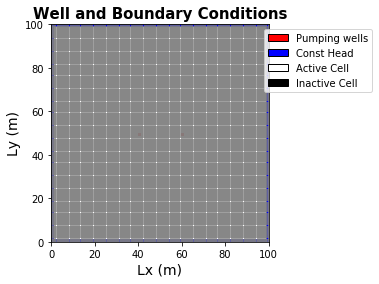

In [10]:
#CHECK WELL LOCATIONS
#use flopy to plot grid, ibound, and wells
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
wel = modelmap.plot_bc(ftype='WEL', kper=0)
wel = modelmap.plot_bc(ftype='WEL', kper=1)
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Well and Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='red',label='Pumping wells',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

### 6. Specify Data Output and Attach OC Package

In [11]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}

#create flopy output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

### 7. Assign PCG as Finite Difference Solver and Attach PCG Package

In [12]:
#assign groundwater flow solver
pcg = flopy.modflow.ModflowPcg(model=m)

### 8. Create MODFLOW files and Run Model

In [13]:
#write MODFLOW input files
m.write_input()

In [14]:
# Run the model
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Applications/MODFLOW/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Pumping_Modeltre_twoWEL.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/02/17 15:48:10

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/02/17 15:48:10
 Elapsed run time:  0.031 Seconds

  Normal termination of simulation



### 9. Extract Head and Flow Data 

In [15]:
#extract binary data from head file
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
head = headobj.get_data(totim=1.0)

In [16]:
#extract binary data from budget file
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)


## 10. Plotting

### Head Contour and Flow Plot 

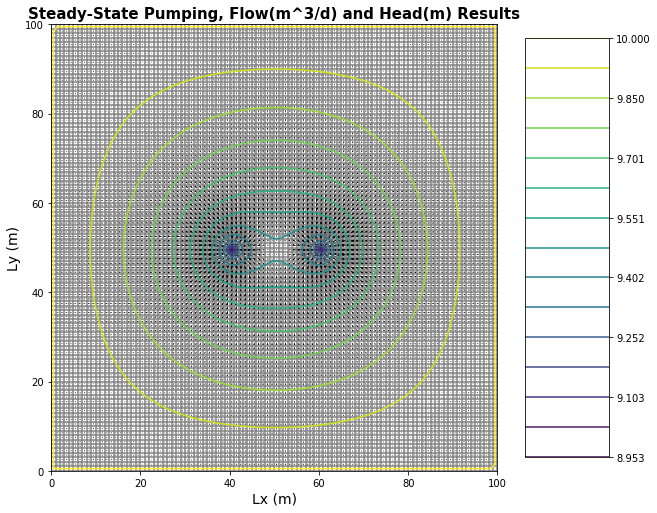

In [17]:
#plot results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Pumping, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)


plt.savefig('Two_pumping_vectors_tre', dpi=500)
plt.show(modelmap)

### Head Contour Plot


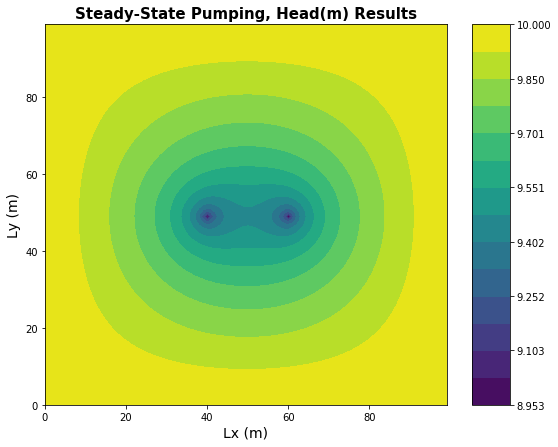

In [18]:
#create plot
plt.figure(figsize=(9,7))
cf = plt.contourf(np.flipud(head[0,:,:]),levels=contour_levels)
#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Pumping, Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(cf,aspect=10)


plt.savefig('Two_pumping_head_tre', dpi=500)
plt.show()

### 3D Head Surface Plot

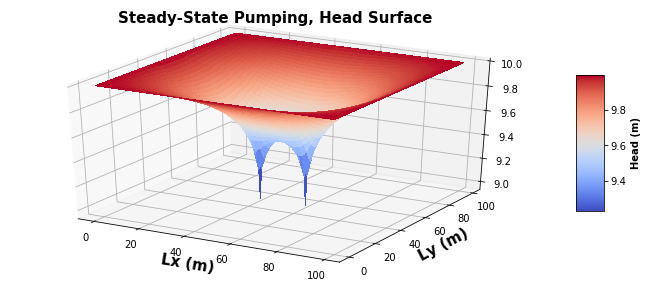

In [19]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Pumping, Head Surface', fontsize=15, fontweight='bold')


plt.savefig('Two_pumping_surface_tre', dpi=500)
plt.show(surf)

### Head Transect Plot


[10.         9.991128   9.982242   9.973327   9.96437    9.955355
  9.946267   9.937092   9.927813   9.918412   9.908874   9.899179
  9.889308   9.87924    9.868952   9.85842    9.847618   9.836516
  9.825084   9.813284   9.801077   9.788419   9.775257   9.761533
  9.747178   9.732112   9.716238   9.69944    9.681578   9.662473
  9.6419     9.619564   9.595069   9.56786    9.537126   9.501604
  9.459146   9.40562    9.331616   9.210814   8.953041   9.194877
  9.29966    9.357477   9.39456    9.420221   9.438481   9.451363
  9.459978   9.464955   9.46662    9.465074   9.460214   9.451716
  9.438953   9.420812   9.39527    9.358308   9.300611   9.1959505
  8.954238   9.212136   9.333064   9.407195   9.460851   9.50344
  9.539095   9.569964   9.597311   9.621947   9.644425   9.665144
  9.684398   9.702412   9.719364   9.735396   9.750626   9.765147
  9.779041   9.792378   9.805216   9.817608   9.829597   9.841225
  9.852528   9.863537   9.874282   9.884789   9.895084   9.9051895
  9.91512

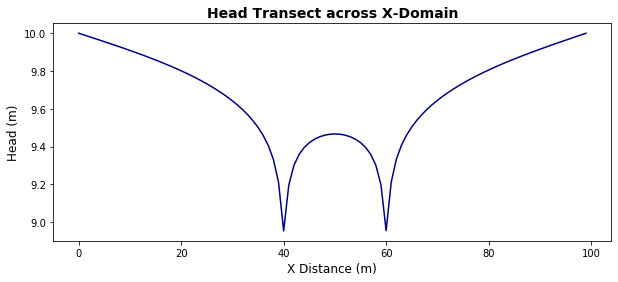

In [20]:
#plot head head transect
plt.figure(figsize = (10,4))
x = np.arange(0,Lx,dx)
plt.plot(x,np.flipud(head[0])[(int(nrow/2)-1)][:],color='navy')
plt.title('Head Transect across X-Domain',fontweight = 'bold', fontsize = 14)
plt.xlabel('X Distance (m)',fontsize = 12)
plt.ylabel('Head (m)',fontsize = 12)
print(np.flipud(head[0])[(int(nrow/2)-1)][:])

plt.savefig('Two_pumping_transect_tre', dpi=500)
plt.show()

In [21]:
import csv

with open('Head_transect_tre.csv', 'w', newline='') as csvfile:  
    writer = csv.writer(csvfile, delimiter=',')   #writes each row
    writer.writerow(x) 
    writer.writerow((head[0])[(int(nrow/2)-1)])